# Skin Cancer Detection

In this project, we will build a model which can predict whether or not an image of someone's skin is cancerous or not.

Before starting, it is recommended to install tensorflow-gpu to accelerate model building, although not required. Tensorflow-gpu requires compatibible versions of CUDA and cuDNN.

# Setup
### Download and Load Libraries

In [1]:
!pip install tensorflow==2.9.1 tensorflow-gpu opencv-python matplotlib

In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

### Configure GPU

In [3]:
print(f'tensorflow version: {tf.__version__}')

tensorflow version: 2.9.1


The below chunk will show if there are any GPUs recognized by tensorflow.

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Getting Data

The images for this project are stored locally but may be obtained on my [Github](https://github.com/fortmaad/Detecting-Skin-Cancer/tree/main/data).

We first define the subfolder where the images are, then define the image type accepted.

In [5]:
data_dir = 'data' # local subfolder with data

image_exts = 'jpg' # supported image types

The data folder consists of two folders for each class:
- Benign: Moles which have been confirmed to be harmless
- Malignant: Cancerous skin cells

In [6]:
# read data
data = tf.keras.utils.image_dataset_from_directory('data',
class_names = ['benign', 'malignant']) 

Found 3297 files belonging to 2 classes.


In [7]:
# create numpy iterator for visualizing data
data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

In [8]:
# show how each batch is stored
batch

(array([[[[ 88.      ,  69.      ,  65.      ],
          [ 87.1875  ,  66.5625  ,  63.375   ],
          [106.9375  ,  79.75    ,  78.8125  ],
          ...,
          [171.25    , 119.375   , 122.375   ],
          [162.8125  , 106.25    , 109.4375  ],
          [162.      , 103.      , 107.      ]],
 
         [[ 95.3125  ,  72.25    ,  68.25    ],
          [112.32422 ,  88.296875,  84.44922 ],
          [136.1875  , 107.42578 , 105.11719 ],
          ...,
          [185.36719 , 132.1211  , 136.4414  ],
          [173.52734 , 116.30469 , 121.77734 ],
          [162.8125  , 103.8125  , 109.4375  ]],
 
         [[110.0625  ,  82.625   ,  78.625   ],
          [133.98047 , 105.171875, 101.73047 ],
          [146.20312 , 113.89844 , 111.48828 ],
          ...,
          [185.27344 , 129.64844 , 134.23047 ],
          [177.5039  , 118.19531 , 125.57031 ],
          [165.0625  , 104.6875  , 112.0625  ]],
 
         ...,
 
         [[160.375   , 144.6875  , 120.3125  ],
          [163.929

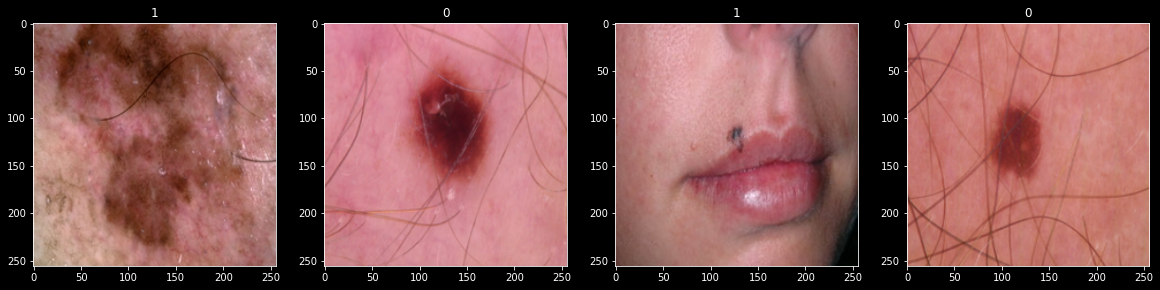

In [9]:
# view images, where 1 is malignant and 0 is benign
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Data Preparation

Before creating the classification model, we should scale the data to be between 0 and 1 for tensorflow.

In [10]:
# scale data
data = data.map(lambda x,y: (x/256, y))

# scaled data
data.as_numpy_iterator().next()

(array([[[[0.6796875 , 0.6171875 , 0.72265625],
          [0.6796875 , 0.6171875 , 0.72265625],
          [0.6743164 , 0.60913086, 0.73339844],
          ...,
          [0.71362305, 0.6525879 , 0.81933594],
          [0.70947266, 0.64453125, 0.8063965 ],
          [0.703125  , 0.64453125, 0.796875  ]],
 
         [[0.689209  , 0.6140137 , 0.72265625],
          [0.6917877 , 0.61917114, 0.7329712 ],
          [0.6826477 , 0.6188507 , 0.7395477 ],
          ...,
          [0.71580505, 0.65338135, 0.8163605 ],
          [0.70887756, 0.6510773 , 0.7974701 ],
          [0.6999512 , 0.6381836 , 0.79052734]],
 
         [[0.6887207 , 0.6159668 , 0.7199707 ],
          [0.69407654, 0.62449646, 0.74357605],
          [0.6993408 , 0.62831116, 0.7572479 ],
          ...,
          [0.71009827, 0.65104675, 0.8030853 ],
          [0.7032013 , 0.64604187, 0.78718567],
          [0.70458984, 0.63671875, 0.79174805]],
 
         ...,
 
         [[0.73291016, 0.6862793 , 0.8215332 ],
          [0.73608

### Create Training, Validation, and Test Sets

We will use 70% of data for training, 20% for validation, and 10% for testing.

In [11]:
# calculating number of images in each set
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [12]:
# create sets
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Build Model

The model used for classification is a convolutional neural network with three convolutional layers with ReLu activation functions and maximum pooling layers. Since the output is binary classification, we use a sigmoid activation function for the output layer.

We will use an Adam optimizer with a binary cross-entropy (log loss) function.

In [13]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='Adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

### Fit Model

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

In [16]:
# train model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
72/72 [==============================] - 25s 87ms/step - loss: 0.6711 - accuracy: 0.6302 - val_loss: 0.5911 - val_accuracy: 0.6500
Epoch 2/20
72/72 [==============================] - 6s 82ms/step - loss: 0.4645 - accuracy: 0.7687 - val_loss: 0.5191 - val_accuracy: 0.7422
Epoch 3/20
72/72 [==============================] - 6s 82ms/step - loss: 0.4355 - accuracy: 0.7812 - val_loss: 0.4657 - val_accuracy: 0.7719
Epoch 4/20
72/72 [==============================] - 6s 83ms/step - loss: 0.4083 - accuracy: 0.7947 - val_loss: 0.4005 - val_accuracy: 0.7969
Epoch 5/20
72/72 [==============================] - 6s 83ms/step - loss: 0.3684 - accuracy: 0.8207 - val_loss: 0.3915 - val_accuracy: 0.8109
Epoch 6/20
72/72 [==============================] - 6s 84ms/step - loss: 0.3588 - accuracy: 0.8242 - val_loss: 0.3889 - val_accuracy: 0.8109
Epoch 7/20
72/72 [==============================] - 6s 83ms/step - loss: 0.3408 - accuracy: 0.8407 - val_loss: 0.3933 - val_accuracy: 0.8078
Epoch 8/20
7

# Model Performance and Evaluation

Below are the plots for loss and accuracy over each epoch.

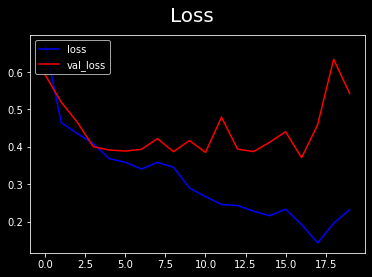

In [17]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='red', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

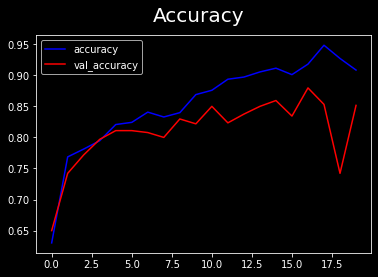

In [18]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='red', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [19]:
# track model metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [20]:
# making predictions for test set and evaluating
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 32ms/step


In [23]:
print(f'Testing Precision: {pre.result()}\nTesting Recall: {re.result()}\nTesting Accuracy: {acc.result()}')

Testing Precision: 0.7972028255462646
Testing Recall: 0.8444444537162781
Testing Accuracy: 0.84375


In [ ]:
# save model
model.save(os.path.join('model','skin_cancer_classifier.h5'))